# Setup
There are several reasons I built this model. First in news people frequently report on things such as risk factor, and I am curious if I can reproduce these results. Intuitively, some things like age, asthma, and whether or not they were admitted to the ICU should have effects in line with what has been widely reported in the media. These could act as a good check for my model, where if I find things like age not correlating with risk factor, I could check for mistakes along the way. Secondly, this is to show my skillset and thought process, and I also hope to get feedback on how this model could be refined.

The end goal of this model to be able to have a train and a test setup, where the test group can have their medical history plugged in and their risk of dying can be out put. To oversimplify the problem, higher risk people may have a greater tolerance of adverse side effects in treatment, higher risk people would want to be treated sooner, and higher risk people would want to be triaged in areas where healthcare resources are scarce. 

There are a few issues with this data. There is a lot of missing data, and beyond that, this data is limited to that of the Mexican Government reporting. Thus, this data will have Mexico-specific biases that may be misleading if they are applied globally.

Data derived from https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download

For booleans, 1 means yes, 2 means no. 97+ on anything besides age is equivalent of NaN

In [1]:
# Installation cell
from sklearn.model_selection import train_test_split
import xgboost as xgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import datetime
from datetime import datetime as dt

import math
import shap

# from sklearn import linear_model
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, auc, roc_curve, mean_squared_error, r2_score
# from sklearn.compose import ColumnTransformer

# Load Data and Exploratory Data Analysis

In [4]:
df = pd.read_csv('Covid Data.csv')
df.head()


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
# Get a better understanding of the columns
df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


# Data Cleaning

In [6]:
# Create a new column that is a boolean for death so that I have a categorical column to manipulate
df["SURVIVED"] = df["DATE_DIED"].str.contains("9999-99-99")


# 97, 98, 99 are set into this data for missing values. This line will replace those with NaNs. 
# Since the model I'm working with (XGBoost) is capable of handling nan values, this is a good way to do this.
df = df.loc[:,df.columns != 'DATE_DIED'].replace({97:np.nan,98:np.nan,99:np.nan})

# # Create a correlation matrix to examine at first glance
#df.head()



In [36]:
# This next block of code makes a comorbidity only dataframe and counts the number of true values in the dataframe. 
# Since a nan value is treated in this case as not a comorbidity, my model will be biased incorrectly here and I will
# Need to take that into account. It will under-report comorbodities.

temp_inputs = df.loc[:, ~df.columns.isin(['DATE_DIED','SURVIVED','AGE','MEDICAL_UNIT','CLASIFFICATION_FINAL','ICU'])]
temp_comorbidities = temp_inputs.loc[:,~temp_inputs.columns.isin(['USMER','SEX','PATIENT_TYPE','INTUBED','PNEUMONIA'])]
comorbidity_count = temp_comorbidities[temp_comorbidities==1].sum(axis=1)
df['COMORBIDITY_COUNT'] = comorbidity_count
df['DIED'] = ~df['SURVIVED']
df.head()


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,SURVIVED,COMORBIDITY_COUNT,DIED
0,2,1,1,1,NaN,1.0,65.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,3,NaN,False,2.0,True
1,2,1,2,1,NaN,1.0,72.0,NaN,2.0,2.0,...,2.0,2.0,1.0,1.0,2.0,5,NaN,False,3.0,True
2,2,1,2,2,1.0,2.0,55.0,NaN,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,3,2.0,False,2.0,True
3,2,1,1,1,NaN,2.0,53.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,7,NaN,False,0.0,True
4,2,1,2,1,NaN,2.0,68.0,NaN,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,3,NaN,False,2.0,True


In [8]:
# Find the correlations and check their trends to make sure it makes sense.
# Overall, I would expect comorbidities to correlate with death
df.corr()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,SURVIVED,COMORBIDITY_COUNT
USMER,1.000000,0.127927,-0.001126,-0.190570,0.014203,0.152041,-0.044973,0.000872,0.056317,0.026497,...,0.052964,0.024478,0.020266,0.007027,0.040169,-0.015632,0.028840,-0.036478,0.112671,-0.058652
MEDICAL_UNIT,0.127927,1.000000,0.001475,-0.205413,0.049875,0.107562,-0.082219,-0.000889,0.071764,0.035768,...,0.091586,0.115694,0.026350,0.026759,0.061558,-0.011406,0.079981,-0.178277,0.149030,-0.110392
SEX,-0.001126,0.001475,1.000000,0.089505,-0.049182,-0.080975,0.028538,NaN,-0.011062,-0.003194,...,-0.003040,0.022531,-0.011086,0.017864,-0.013687,-0.102238,-0.057782,-0.026479,-0.081383,0.010347
PATIENT_TYPE,-0.190570,-0.205413,0.089505,1.000000,NaN,-0.653553,0.314897,-0.030129,-0.256325,-0.119065,...,-0.232767,-0.093410,-0.103882,-0.064362,-0.148742,-0.005828,-0.183370,NaN,-0.515582,0.278664
INTUBED,0.014203,0.049875,-0.049182,NaN,1.000000,0.156074,-0.096168,-0.041493,0.045945,0.002311,...,0.057186,0.011654,0.011330,0.038709,0.006738,0.010599,0.124715,0.308095,0.414985,-0.054882
PNEUMONIA,0.152041,0.107562,-0.080975,-0.653553,0.156074,1.000000,-0.280636,-0.012506,0.217117,0.093618,...,0.192215,0.055075,0.081837,0.072664,0.105663,0.011869,0.193510,0.142559,0.471559,-0.229829
AGE,-0.044973,-0.082219,0.028538,0.314897,-0.096168,-0.280636,1.000000,0.100690,-0.331907,-0.166430,...,-0.391809,-0.038205,-0.131070,-0.090419,-0.101446,-0.014863,-0.152975,0.023519,-0.320613,0.353765
PREGNANT,0.000872,-0.000889,NaN,-0.030129,-0.041493,-0.012506,0.100690,1.000000,-0.034295,-0.012009,...,-0.043720,0.017198,-0.012354,-0.027526,-0.012650,-0.017258,-0.004717,0.007123,-0.023429,-0.084714
DIABETES,0.056317,0.071764,-0.011062,-0.256325,0.045945,0.217117,-0.331907,-0.034295,1.000000,0.097450,...,0.379119,0.032301,0.108663,0.117159,0.167494,0.014248,0.095798,0.008120,0.217199,-0.597616
COPD,0.026497,0.035768,-0.003194,-0.119065,0.002311,0.093618,-0.166430,-0.012009,0.097450,1.000000,...,0.117802,0.036697,0.110485,0.039260,0.066040,0.065103,0.008201,-0.006383,0.090238,-0.281688


# Set up the XGBoost Model

The biggest takeaway right off the bat, age is an order of magnitude more important than any other pre-existing conditions. Moving forward, I'm going to take a deeper dive into the data to see how we can glean meaningful actions from this data set.

In [37]:
# Last row is Survival, all the other factors I want to know how they impact things
inputs = df.loc[:, ~df.columns.isin(['DATE_DIED','SURVIVED','MEDICAL_UNIT','CLASIFFICATION_FINAL','ICU','DIED'])]
#inputs = df[['AGE', 'COMORBIDITY_COUNT']]
outputs = df.loc[:,'DIED']

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.3, random_state=7)

train = xgb.DMatrix(X_train, label = y_train)
test = xgb.DMatrix(X_test, label = y_test)


In [38]:
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


In [39]:
# Calculate model accuracy, precision, and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall_score = recall_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)

print("Accuracy Score: %.2f%%" % (accuracy * 100.0))
print("Precision Score: %.2f%%" % (precision * 100.0))
print("Recall Score: %.2f%%" % (recall_score * 100.0))
print("F1 Score: %.2f%%" % (f1_score * 100.0))

Accuracy Score: 94.62%
Precision Score: 72.83%
Recall Score: 43.09%
F1 Score: 54.14%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

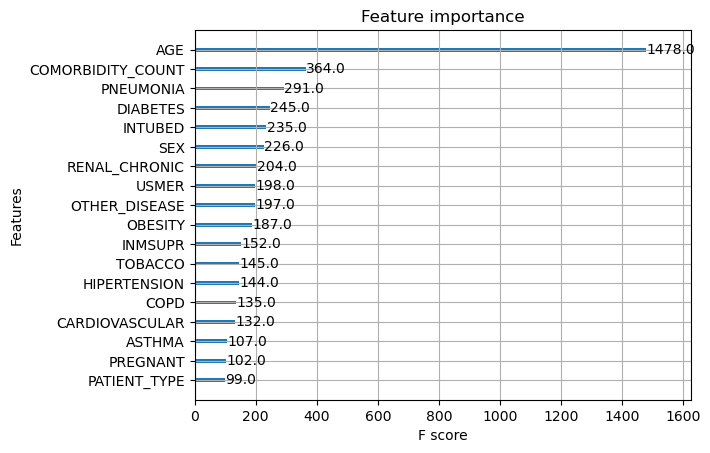

In [40]:
xgb.plot_importance(model)

In [41]:
confusion = confusion_matrix(y_test,y_pred)
confusion

array([[287663,   3726],
       [ 13195,   9989]])

# Evaluating Senior Citizens Pre-Existing Conditions
Now that it's been established that age is far and away the most important factor, I wanted to check to see how senior citizens are affected by pre-existed conditions

In [47]:
# Last row is Survival, all the other factors I want to know how they impact things
df_range = df[df['AGE'].between(65,75)]

inputs_range = df_range.loc[:, ~df_range.columns.isin(['DATE_DIED','AGE','SURVIVED','MEDICAL_UNIT','CLASIFFICATION_FINAL','ICU','DIED'])]
outputs_range = df_range.loc[:,'SURVIVED']

X_train_range, X_test_range, y_train_range, y_test_range = train_test_split(inputs_range, outputs_range, test_size=0.3, random_state=7)

train_range = xgb.DMatrix(X_train_range, label = y_train_range)
test_range = xgb.DMatrix(X_test_range, label = y_test_range)

In [48]:
model_range = XGBClassifier()
model_range.fit(X_train_range, y_train_range)

# make predictions for test data
y_pred_range = model_range.predict(X_test_range)
predictions_range = [round(value) for value in y_pred_range]
accuracy_range = accuracy_score(y_test_range, predictions_range)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.62%


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_range = accuracy_score(y_test_range, predictions_range)
precision_range = precision_score(y_test_range, predictions_range)
recall_score_range = recall_score(y_test_range, predictions_range)
f1_score_range = f1_score(y_test_range, predictions_range)

print("Accuracy Score: %.2f%%" % (accuracy_range * 100.0))
print("Precision Score: %.2f%%" % (precision_range * 100.0))
print("Recall Score: %.2f%%" % (recall_score_range * 100.0))
print("F1 Score: %.2f%%" % (f1_score_range * 100.0))

Accuracy Score: 79.21%
Precision Score: 81.38%
Recall Score: 91.33%
F1 Score: 86.07%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

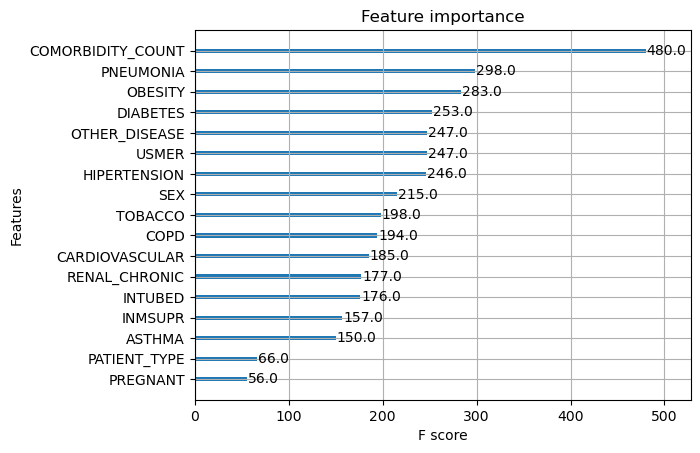

In [50]:
xgb.plot_importance(model_range)

In [ ]:
shap.initjs()
explainer = shap.Explainer(model_range)
shap_values = explainer.shap_values(X_train_range)
shap.summary_plot(shap_values, X_train_range)

In [51]:
from sklearn.metrics import confusion_matrix
confusion_range = confusion_matrix(y_test_range,y_pred_range)
confusion_range

array([[ 3068,  3011],
       [ 1249, 13158]])

In [52]:
#EDA 
survived_df = df.loc[df['SURVIVED'] == True]
died_df = df.loc[df['SURVIVED'] == False]

In [53]:
survived_df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,COMORBIDITY_COUNT
count,971633.000000,971633.00000,971633.000000,971633.000000,124724.000000,956364.000000,971394.000000,493975.000000,969026.000000,969341.000000,...,968984.000000,969219.000000,967622.000000,969290.000000,969316.000000,969330.000000,969138.000000,971633.000000,124573.000000,971633.000000
mean,1.647483,9.13671,1.487809,1.133759,1.941671,1.909956,40.253609,1.983720,1.900184,1.988610,...,1.988078,1.865182,1.975720,1.983148,1.852966,1.986385,1.919743,5.409454,1.930458,0.821875
std,0.477754,3.68272,0.499852,0.340394,0.234365,0.286245,16.040430,0.126551,0.299754,0.106115,...,0.108534,0.341529,0.153918,0.128715,0.354140,0.115884,0.271691,1.855580,0.254374,1.089870
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,4.00000,1.000000,1.000000,2.000000,2.000000,29.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,2.000000,12.00000,1.000000,1.000000,2.000000,2.000000,39.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6.000000,2.000000,0.000000
75%,2.000000,12.00000,2.000000,1.000000,2.000000,2.000000,50.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.000000,2.000000,2.000000
max,2.000000,13.00000,2.000000,2.000000,2.000000,2.000000,121.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.000000,2.000000,11.000000


In [54]:
died_df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,COMORBIDITY_COUNT
count,76942.000000,76942.000000,76942.000000,76942.000000,67982.000000,76208.000000,76836.000000,27335.000000,76211.000000,76231.000000,...,76187.000000,76252.000000,75908.000000,76209.000000,76227.000000,76239.000000,76217.000000,76942.000000,67970.000000,76942.000000
mean,1.439123,7.008747,1.643862,1.910634,1.611941,1.292423,61.017960,1.996744,1.629122,1.947252,...,1.965637,1.579539,1.940112,1.941805,1.773125,1.925143,1.913458,3.994840,1.879432,1.685425
std,0.496283,3.668800,0.478860,0.285273,0.487312,0.454879,15.316506,0.056969,0.483043,0.223531,...,0.182161,0.493636,0.237281,0.234114,0.418814,0.263162,0.281165,1.700541,0.325627,1.235009
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,4.000000,1.000000,2.000000,1.000000,1.000000,52.000000,2.000000,1.000000,2.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,1.000000,4.000000,2.000000,2.000000,2.000000,1.000000,62.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
75%,2.000000,12.000000,2.000000,2.000000,2.000000,2.000000,72.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6.000000,2.000000,2.000000
max,2.000000,13.000000,2.000000,2.000000,2.000000,2.000000,119.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.000000,2.000000,10.000000
